# Задание
**Оптимизация гиперпараметров с использованием нескольких моделей**:
   1. Используйте генетический алгоритм для оптимизации гиперпараметров нескольких моделей (например, CNN, RNN, MLP) на одном наборе данных.
   2. Сравните результаты и выберите лучшую модель.



In [ ]:
#@title Установка зависимостей
!pip install -q matplotlib scikit-learn > /dev/null 2>&1

In [ ]:
#@title Импорты

import random
import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

In [ ]:
#@title Константы и гиперпараметры ГА

# Фиксируем сид для воспроизводимости
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Основные параметры данных CIFAR-10
NUM_CLASSES = 10
IMG_ROWS = 32
IMG_COLS = 32
IMG_CHANNELS = 3

# Параметры обучения моделей
EPOCHS_FITNESS = 3   # эпох на шаге ГА (оценка хромосомы)
VERBOSE_FITNESS = 0  # 0 — без логов, 1 — с логами

# Параметры генетического алгоритма
POPULATION_SIZE = 8
N_GENERATIONS = 4
NSURV = 4             # сколько лучших особей переходит в следующее поколение
MUTATION_RATE = 0.3   # базовый коэффициент мутаций

# Типы моделей
MODEL_TYPE_MLP = 0
MODEL_TYPE_CNN = 1
MODEL_TYPE_RNN = 2
MODEL_TYPE_NAMES = {
    MODEL_TYPE_MLP: "MLP",
    MODEL_TYPE_CNN: "CNN",
    MODEL_TYPE_RNN: "RNN",
}

In [ ]:
#@title Загрузка и подготовка данных (CIFAR-10)

# Загружаем данные CIFAR-10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Приводим к float32 и нормируем
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Для CNN/MLP уже есть размерность канала: (N, 32, 32, 3)
x_train_img = x_train
x_test_img = x_test

# Для RNN используем последовательности из строк:
# 32 временных шага по (32 * 3) признаков
x_train_seq = x_train.reshape(-1, IMG_ROWS, IMG_COLS * IMG_CHANNELS)
x_test_seq = x_test.reshape(-1, IMG_ROWS, IMG_COLS * IMG_CHANNELS)

# y в CIFAR-10 имеет форму (N, 1), выравниваем
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

# One-hot для меток
y_train_cat = to_categorical(y_train, NUM_CLASSES)
y_test_cat = to_categorical(y_test, NUM_CLASSES)

# Отделяем валидационную выборку от обучающей
x_train_img, x_val_img, y_train_cat, y_val_cat, x_train_seq, x_val_seq = train_test_split(
    x_train_img,
    y_train_cat,
    x_train_seq,
    test_size=0.2,
    random_state=SEED,
    stratify=y_train,
)

print("Форма x_train_img:", x_train_img.shape)
print("Форма x_val_img:  ", x_val_img.shape)
print("Форма x_test_img: ", x_test_img.shape)
print("Форма x_train_seq:", x_train_seq.shape)
print("Форма x_val_seq:  ", x_val_seq.shape)
print("Форма x_test_seq: ", x_test_seq.shape)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step
Форма x_train_img: (40000, 32, 32, 3)
Форма x_val_img:   (10000, 32, 32, 3)
Форма x_test_img:  (10000, 32, 32, 3)
Форма x_train_seq: (40000, 32, 96)
Форма x_val_seq:   (10000, 32, 96)
Форма x_test_seq:  (10000, 32, 96)


In [ ]:
#@title Генотип: тип модели и гиперпараметры

def random_learning_rate():
    """Сгенерировать случайный learning rate.

    Диапазон подбирается логарифмически в интервале [1e-4, 1e-2].

    Returns:
        float: Случайное значение скорости обучения.
    """
    return 10 ** random.uniform(-4, -2)


def random_dropout():
    """Сгенерировать случайный коэффициент dropout.

    Диапазон от 0.0 до 0.5.

    Returns:
        float: Случайное значение dropout, округлённое до двух знаков.
    """
    return round(random.uniform(0.0, 0.5), 2)


def random_units():
    """Сгенерировать случайное количество нейронов / фильтров.

    Значение выбирается из фиксированного набора.

    Returns:
        int: Количество нейронов/фильтров (32, 64, 96 или 128).
    """
    return random.choice([32, 64, 96, 128])


def random_chromosome():
    """Сгенерировать одну случайную хромосому (генотип).

    Хромосома кодирует:
        - тип модели (MLP/CNN/RNN),
        - размеры скрытых слоёв,
        - dropout,
        - learning rate,
        - размер батча.

    Returns:
        dict: Словарь с гиперпараметрами, описывающими одну особь популяции.
    """
    chromosome = {
        "model_type": random.randint(0, 2),
        "num_units1": random_units(),
        "num_units2": random.choice([0, random_units()]),
        "dropout": random_dropout(),
        "learning_rate": random_learning_rate(),
        "batch_size": random.choice([32, 64, 128]),
    }
    return chromosome


def chromosome_to_string(ch):
    """Вернуть человекочитаемое строковое представление хромосомы.

    Args:
        ch (dict): Хромосома с полями model_type, num_units1, num_units2,
            dropout, learning_rate, batch_size.

    Returns:
        str: Строка с кратким описанием гиперпараметров.
    """
    return (
        f"model={MODEL_TYPE_NAMES[ch['model_type']]}, "
        f"u1={ch['num_units1']}, u2={ch['num_units2']}, "
        f"dropout={ch['dropout']}, lr={ch['learning_rate']:.4f}, "
        f"batch={ch['batch_size']}"
    )

In [ ]:
#@title Построение моделей по хромосоме (MLP / CNN / RNN)


def build_mlp(ch):
    """Построить MLP-модель по хромосоме.

    Args:
        ch (dict): Хромосома с полями:
            - "num_units1" (int): количество нейронов в первом скрытом слое,
            - "num_units2" (int): количество нейронов во втором слое (0 = слой отсутствует),
            - "dropout" (float): вероятность dropout.

    Returns:
        tf.keras.Model: Собранная, но нескомпилированная MLP-модель.
    """
    num_units1 = ch["num_units1"]
    num_units2 = ch["num_units2"]
    dropout = ch["dropout"]

    model = models.Sequential()
    model.add(layers.Input(shape=(IMG_ROWS, IMG_COLS, IMG_CHANNELS)))
    model.add(layers.Flatten())
    model.add(layers.Dense(num_units1, activation="relu"))
    if dropout > 0.0:
        model.add(layers.Dropout(dropout))
    if num_units2 > 0:
        model.add(layers.Dense(num_units2, activation="relu"))
        if dropout > 0.0:
            model.add(layers.Dropout(dropout))
    model.add(layers.Dense(NUM_CLASSES, activation="softmax"))
    return model


def build_cnn(ch):
    """Построить CNN-модель по хромосоме.

    Args:
        ch (dict): Хромосома с полями:
            - "num_units1" (int): количество фильтров в первом Conv2D-слое,
            - "num_units2" (int): количество фильтров во втором Conv2D-слое (0 = отсутствует),
            - "dropout" (float): вероятность dropout.

    Returns:
        tf.keras.Model: Собранная, но нескомпилированная CNN-модель.
    """
    num_filters1 = ch["num_units1"]
    num_filters2 = ch["num_units2"]
    dropout = ch["dropout"]

    model = models.Sequential()
    model.add(layers.Input(shape=(IMG_ROWS, IMG_COLS, IMG_CHANNELS)))
    model.add(layers.Conv2D(num_filters1, (3, 3), activation="relu", padding="same"))
    model.add(layers.MaxPooling2D((2, 2)))
    if num_filters2 > 0:
        model.add(layers.Conv2D(num_filters2, (3, 3), activation="relu", padding="same"))
        model.add(layers.MaxPooling2D((2, 2)))
    if dropout > 0.0:
        model.add(layers.Dropout(dropout))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation="relu"))
    if dropout > 0.0:
        model.add(layers.Dropout(dropout))
    model.add(layers.Dense(NUM_CLASSES, activation="softmax"))
    return model


def build_rnn(ch):
    """Построить RNN-модель (LSTM) по хромосоме.

    Для стабильности ограничивает размер слоёв максимум 64 нейронами
    и добавляет recurrent_dropout для LSTM.

    Args:
        ch (dict): Хромосома с полями:
            - "num_units1" (int): количество единиц в первом LSTM-слое,
            - "num_units2" (int): количество единиц во втором LSTM-слое (0 = отсутствует),
            - "dropout" (float): коэффициент обычного dropout.

    Returns:
        tf.keras.Model: Собранная, но нескомпилированная RNN-модель.
    """
    num_units1 = ch["num_units1"]
    num_units2 = ch["num_units2"]
    dropout = ch["dropout"]

    num_units1 = min(num_units1, 64)
    if num_units2 > 0:
        num_units2 = min(num_units2, 64)

    model = models.Sequential()
    model.add(layers.Input(shape=(IMG_ROWS, IMG_COLS * IMG_CHANNELS)))  # (timesteps=32, features=96)

    recurrent_dropout = min(dropout, 0.2) if dropout > 0.0 else 0.0
    model.add(
        layers.LSTM(
            num_units1,
            return_sequences=(num_units2 > 0),
            recurrent_dropout=recurrent_dropout,
        )
    )
    if dropout > 0.0:
        model.add(layers.Dropout(dropout))
    if num_units2 > 0:
        model.add(
            layers.LSTM(
                num_units2,
                recurrent_dropout=recurrent_dropout,
            )
        )
        if dropout > 0.0:
            model.add(layers.Dropout(dropout))
    model.add(layers.Dense(NUM_CLASSES, activation="softmax"))
    return model


def build_model_from_chromosome(ch):
    """Построить и скомпилировать модель по хромосоме, подобрать нужные данные.

    В зависимости от типа модели (MLP/CNN/RNN) использует:
      - изображения в формате (N, 32, 32, 3) для MLP/CNN,
      - последовательности (N, 32, 96) для RNN.

    Для RNN дополнительно ограничивает learning rate и включает gradient clipping.

    Args:
        ch (dict): Хромосома с полями model_type, num_units1, num_units2,
            dropout, learning_rate, batch_size.

    Returns:
        tuple: (модель, (x_train_part, y_train_part), (x_val_part, y_val_part)).
    """
    model_type = ch["model_type"]
    lr = ch["learning_rate"]

    if model_type == MODEL_TYPE_MLP:
        model = build_mlp(ch)
        x_tr, x_val = x_train_img, x_val_img
        optimizer = Adam(learning_rate=lr)
    elif model_type == MODEL_TYPE_CNN:
        model = build_cnn(ch)
        x_tr, x_val = x_train_img, x_val_img
        optimizer = Adam(learning_rate=lr)
    elif model_type == MODEL_TYPE_RNN:
        model = build_rnn(ch)
        x_tr, x_val = x_train_seq, x_val_seq
        lr = min(lr, 0.001)
        optimizer = Adam(learning_rate=lr, clipnorm=1.0)
    else:
        raise ValueError("Неизвестный тип модели")

    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
    return model, (x_tr, y_train_cat), (x_val, y_val_cat)

In [ ]:
#@title Функция приспособленности (fitness_function)

# Кэш уже обученных хромосом, чтобы не переобучать одинаковые
fitness_cache = {}


def chromosome_key(ch):
    """Сформировать ключ для кэширования значения фитнеса.

    Округляет некоторые параметры, чтобы одинаковые хромосомы
    давали один и тот же ключ.

    Args:
        ch (dict): Хромосома с гиперпараметрами.

    Returns:
        tuple: Ключ, пригодный для использования в словаре fitness_cache.
    """
    return (
        ch["model_type"],
        ch["num_units1"],
        ch["num_units2"],
        float(f"{ch['dropout']:.2f}"),
        float(f"{ch['learning_rate']:.6f}"),
        ch["batch_size"],
    )


def fitness_function(ch):
    """Вычислить функцию приспособленности для одной хромосомы.

    Обучает соответствующую модель несколько эпох и использует
    последнюю val_accuracy как целевую метрику, затем возвращает
    её с минусом (минимизируем -accuracy).

    Args:
        ch (dict): Хромосома с гиперпараметрами модели.

    Returns:
        float: Значение фитнеса (отрицательная валидационная точность).
    """
    key = chromosome_key(ch)
    if key in fitness_cache:
        return fitness_cache[key]

    model, (x_tr, y_tr), (x_val, y_val) = build_model_from_chromosome(ch)
    history = model.fit(
        x_tr,
        y_tr,
        epochs=EPOCHS_FITNESS,
        batch_size=ch["batch_size"],
        validation_data=(x_val, y_val),
        verbose=VERBOSE_FITNESS,
    )

    val_acc = history.history["val_accuracy"][-1]
    fitness = -float(val_acc)
    fitness_cache[key] = fitness

    tf.keras.backend.clear_session()

    return fitness

In [ ]:
#@title Операторы ГА: отбор, кроссовер, мутация


def getSurvPopul(popul, val, nsurv):
    """Отобрать лучших особей по значению фитнеса.

    Args:
        popul (list): Список хромосом (особей).
        val (list): Список значений фитнеса для каждой особи.
        nsurv (int): Количество выживших особей.

    Returns:
        tuple: (список лучших особей, список соответствующих значений фитнеса).
    """
    pairs = list(zip(val, popul))
    pairs.sort(key=lambda x: x[0])
    sorted_vals = [p[0] for p in pairs]
    sorted_pop = [p[1] for p in pairs]
    return sorted_pop[:nsurv], sorted_vals[:nsurv]


def getParents(popul, nsurv):
    """Выбрать двух родителей из числа лучших особей.

    Args:
        popul (list): Популяция (отсортированная по качеству).
        nsurv (int): Количество лучших особей, из которых выбираем родителей.

    Returns:
        tuple: Две хромосомы-родителя.
    """
    return random.sample(popul[:nsurv], 2)


def crossover(parent1, parent2):
    """Выполнить одноточечный кроссовер двух родителей.

    На уровне словаря по каждому ключу выбираем значение
    либо из первого, либо из второго родителя.

    Args:
        parent1 (dict): Первая родительская хромосома.
        parent2 (dict): Вторая родительская хромосома.

    Returns:
        dict: Новая хромосома-потомок.
    """
    child = {}
    for k in parent1.keys():
        if random.random() < 0.5:
            child[k] = parent1[k]
        else:
            child[k] = parent2[k]
    return child


def mutate(ch, mut_rate):
    """Применить мутацию к хромосоме.

    С вероятностью mut_rate каждый ген может быть заменён
    на новое случайное значение.

    Args:
        ch (dict): Исходная хромосома.
        mut_rate (float): Вероятность мутации каждого гена.

    Returns:
        dict: Новая хромосома после мутаций.
    """
    new_ch = ch.copy()

    if random.random() < mut_rate:
        new_ch["model_type"] = random.randint(0, 2)
    if random.random() < mut_rate:
        new_ch["num_units1"] = random_units()
    if random.random() < mut_rate:
        new_ch["num_units2"] = random.choice([0, random_units()])
    if random.random() < mut_rate:
        new_ch["dropout"] = random_dropout()
    if random.random() < mut_rate:
        new_ch["learning_rate"] = random_learning_rate()
    if random.random() < mut_rate:
        new_ch["batch_size"] = random.choice([32, 64, 128])

    return new_ch

In [ ]:
#@title Функция запуска цикла генетического алгоритма


def run_ga(model_type=None, generations=N_GENERATIONS, pop_size=POPULATION_SIZE, mut_rate=MUTATION_RATE):
    """Запустить генетический алгоритм для заданного типа модели.

    Если model_type задан, тип модели фиксирован (MLP/CNN/RNN).
    Если model_type равен None, тип модели может мутировать (смешанный режим).

    Args:
        model_type (int, optional): Тип модели (MODEL_TYPE_MLP, MODEL_TYPE_CNN,
            MODEL_TYPE_RNN) или None для смешанного режима.
        generations (int): Количество поколений ГА.
        pop_size (int): Размер популяции в каждом поколении.
        mut_rate (float): Базовая вероятность мутации каждого гена.

    Returns:
        dict: Результаты ГА:
            - "best_chromosome": лучшая найденная хромосома,
            - "best_fitness": её значение фитнеса,
            - "best_hist": список лучших фитнесов по поколениям,
            - "avg_hist": список средних фитнесов по поколениям.
    """
    best_hist = []
    avg_hist = []

    best_overall_chromosome = None
    best_overall_fitness = float("inf")

    # Инициализация популяции
    population = []
    for _ in range(pop_size):
        ch = random_chromosome()
        if model_type is not None:
            ch["model_type"] = model_type
        population.append(ch)

    for it in range(generations):
        name = MODEL_TYPE_NAMES[model_type] if model_type is not None else "Mixed"
        print(f"\nПоколение {it + 1}/{generations} для {name}")

        fitness_vals = []
        for i, ch in enumerate(population):
            f = fitness_function(ch)
            fitness_vals.append(f)
            print(f"Особь {i + 1}: {chromosome_to_string(ch)} -> fitness={f:.4f} (val_acc={-f:.4f})")

            if f < best_overall_fitness:
                best_overall_fitness = f
                best_overall_chromosome = ch

        gen_best = min(fitness_vals)
        gen_avg = sum(fitness_vals) / len(fitness_vals)
        best_hist.append(gen_best)
        avg_hist.append(gen_avg)

        print(f"Лучший fitness в поколении: {gen_best:.4f} (val_acc={-gen_best:.4f})")
        print(f"Текущий лучший: {chromosome_to_string(best_overall_chromosome)}, val_acc={-best_overall_fitness:.4f}")

        survivors, _ = getSurvPopul(population, fitness_vals, NSURV)
        new_population = survivors.copy()

        while len(new_population) < pop_size:
            p1, p2 = getParents(survivors, NSURV)
            child = crossover(p1, p2)
            child = mutate(child, mut_rate)
            if model_type is not None:
                child["model_type"] = model_type
            new_population.append(child)

        population = new_population

    print("\nГА завершён для", name)
    print("Лучшая хромосома:", chromosome_to_string(best_overall_chromosome))
    print("Лучший val_accuracy:", -best_overall_fitness)

    return {
        "best_chromosome": best_overall_chromosome,
        "best_fitness": best_overall_fitness,
        "best_hist": best_hist,
        "avg_hist": avg_hist,
    }

In [ ]:
#@title Запуск ГА для MLP

start_time = time.time()
ga_mlp = run_ga(model_type=MODEL_TYPE_MLP)
end_time = time.time()

print(f"Время работы ГА для MLP: {end_time - start_time:.2f} секунд")

best_mlp_chromosome = ga_mlp["best_chromosome"]
best_mlp_fitness = ga_mlp["best_fitness"]
best_mlp_hist = ga_mlp["best_hist"]
avg_mlp_hist = ga_mlp["avg_hist"]


Поколение 1/4 для MLP
Особь 1: model=MLP, u1=32, u2=32, dropout=0.12, lr=0.0002, batch=32 -> fitness=-0.3453 (val_acc=0.3453)
Особь 2: model=MLP, u1=32, u2=0, dropout=0.01, lr=0.0003, batch=128 -> fitness=-0.3746 (val_acc=0.3746)
Особь 3: model=MLP, u1=32, u2=64, dropout=0.11, lr=0.0015, batch=32 -> fitness=-0.1835 (val_acc=0.1835)
Особь 4: model=MLP, u1=128, u2=96, dropout=0.08, lr=0.0082, batch=64 -> fitness=-0.1762 (val_acc=0.1762)
Особь 5: model=MLP, u1=32, u2=0, dropout=0.18, lr=0.0005, batch=64 -> fitness=-0.2572 (val_acc=0.2572)
Особь 6: model=MLP, u1=128, u2=32, dropout=0.04, lr=0.0004, batch=128 -> fitness=-0.3909 (val_acc=0.3909)
Особь 7: model=MLP, u1=96, u2=0, dropout=0.02, lr=0.0003, batch=64 -> fitness=-0.3901 (val_acc=0.3901)
Особь 8: model=MLP, u1=64, u2=32, dropout=0.14, lr=0.0019, batch=64 -> fitness=-0.2919 (val_acc=0.2919)
Лучший fitness в поколении: -0.3909 (val_acc=0.3909)
Текущий лучший: model=MLP, u1=128, u2=32, dropout=0.04, lr=0.0004, batch=128, val_acc=0.390

In [ ]:
#@title Запуск ГА для CNN

start_time = time.time()
ga_cnn = run_ga(model_type=MODEL_TYPE_CNN)
end_time = time.time()

print(f"Время работы ГА для CNN: {end_time - start_time:.2f} секунд")

best_cnn_chromosome = ga_cnn["best_chromosome"]
best_cnn_fitness = ga_cnn["best_fitness"]
best_cnn_hist = ga_cnn["best_hist"]
avg_cnn_hist = ga_cnn["avg_hist"]


Поколение 1/4 для CNN
Особь 1: model=CNN, u1=32, u2=96, dropout=0.32, lr=0.0006, batch=128 -> fitness=-0.6189 (val_acc=0.6189)
Особь 2: model=CNN, u1=32, u2=32, dropout=0.09, lr=0.0084, batch=64 -> fitness=-0.4974 (val_acc=0.4974)
Особь 3: model=CNN, u1=32, u2=128, dropout=0.36, lr=0.0004, batch=128 -> fitness=-0.5966 (val_acc=0.5966)
Особь 4: model=CNN, u1=32, u2=0, dropout=0.13, lr=0.0026, batch=32 -> fitness=-0.5643 (val_acc=0.5643)
Особь 5: model=CNN, u1=64, u2=96, dropout=0.03, lr=0.0021, batch=64 -> fitness=-0.6703 (val_acc=0.6703)
Особь 6: model=CNN, u1=96, u2=32, dropout=0.25, lr=0.0022, batch=64 -> fitness=-0.5772 (val_acc=0.5772)
Особь 7: model=CNN, u1=96, u2=0, dropout=0.21, lr=0.0076, batch=128 -> fitness=-0.3897 (val_acc=0.3897)
Особь 8: model=CNN, u1=64, u2=96, dropout=0.27, lr=0.0001, batch=64 -> fitness=-0.5367 (val_acc=0.5367)
Лучший fitness в поколении: -0.6703 (val_acc=0.6703)
Текущий лучший: model=CNN, u1=64, u2=96, dropout=0.03, lr=0.0021, batch=64, val_acc=0.6703

In [ ]:
#@title Запуск ГА для RNN

start_time = time.time()
ga_rnn = run_ga(model_type=MODEL_TYPE_RNN)
end_time = time.time()

print(f"Время работы ГА для RNN: {end_time - start_time:.2f} секунд")

best_rnn_chromosome = ga_rnn["best_chromosome"]
best_rnn_fitness = ga_rnn["best_fitness"]
best_rnn_hist = ga_rnn["best_hist"]
avg_rnn_hist = ga_rnn["avg_hist"]


Поколение 1/4 для RNN
Особь 1: model=RNN, u1=32, u2=64, dropout=0.3, lr=0.0045, batch=64 -> fitness=-0.4189 (val_acc=0.4189)
Особь 2: model=RNN, u1=32, u2=128, dropout=0.35, lr=0.0077, batch=128 -> fitness=-0.4175 (val_acc=0.4175)
Особь 3: model=RNN, u1=128, u2=0, dropout=0.3, lr=0.0060, batch=128 -> fitness=-0.4030 (val_acc=0.4030)
Особь 4: model=RNN, u1=96, u2=0, dropout=0.11, lr=0.0022, batch=128 -> fitness=-0.4125 (val_acc=0.4125)
Особь 5: model=RNN, u1=32, u2=0, dropout=0.38, lr=0.0002, batch=128 -> fitness=-0.3043 (val_acc=0.3043)
Особь 6: model=RNN, u1=128, u2=0, dropout=0.5, lr=0.0007, batch=64 -> fitness=-0.3903 (val_acc=0.3903)
Особь 7: model=RNN, u1=128, u2=96, dropout=0.17, lr=0.0022, batch=32 -> fitness=-0.4550 (val_acc=0.4550)
Особь 8: model=RNN, u1=128, u2=128, dropout=0.33, lr=0.0006, batch=128 -> fitness=-0.4237 (val_acc=0.4237)
Лучший fitness в поколении: -0.4550 (val_acc=0.4550)
Текущий лучший: model=RNN, u1=128, u2=96, dropout=0.17, lr=0.0022, batch=32, val_acc=0.4

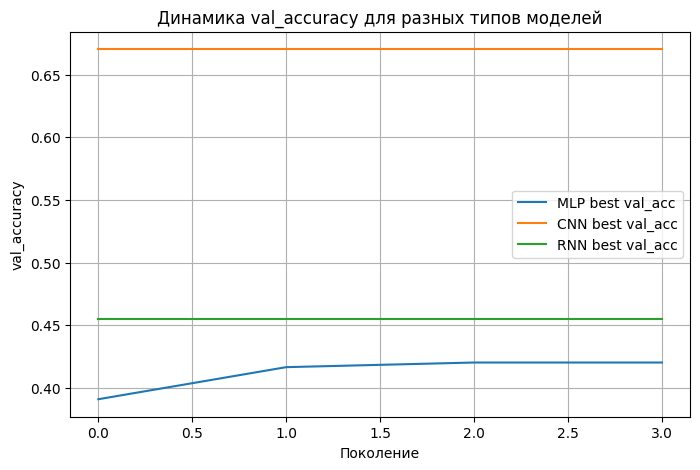

Лучшие хромосомы по типам моделей (если были запущены ГА):
MLP: model=MLP, u1=96, u2=96, dropout=0.02, lr=0.0004, batch=128 val_acc= 0.420199990272522
CNN: model=CNN, u1=64, u2=96, dropout=0.03, lr=0.0021, batch=64 val_acc= 0.6703000068664551
RNN: model=RNN, u1=128, u2=96, dropout=0.17, lr=0.0022, batch=32 val_acc= 0.45500001311302185


In [ ]:
#@title Визуализация сходимости ГА (по типам моделей)

plt.figure(figsize=(8, 5))

if 'best_mlp_hist' in globals():
    plt.plot([-v for v in best_mlp_hist], label="MLP best val_acc")
if 'best_cnn_hist' in globals():
    plt.plot([-v for v in best_cnn_hist], label="CNN best val_acc")
if 'best_rnn_hist' in globals():
    plt.plot([-v for v in best_rnn_hist], label="RNN best val_acc")

plt.xlabel("Поколение")
plt.ylabel("val_accuracy")
plt.title("Динамика val_accuracy для разных типов моделей")
plt.grid(True)
plt.legend()
plt.show()

print("Лучшие хромосомы по типам моделей (если были запущены ГА):")
if 'best_mlp_chromosome' in globals():
    print("MLP:", chromosome_to_string(best_mlp_chromosome), "val_acc=", -best_mlp_fitness)
if 'best_cnn_chromosome' in globals():
    print("CNN:", chromosome_to_string(best_cnn_chromosome), "val_acc=", -best_cnn_fitness)
if 'best_rnn_chromosome' in globals():
    print("RNN:", chromosome_to_string(best_rnn_chromosome), "val_acc=", -best_rnn_fitness)

In [ ]:
#@title Дообучение лучших моделей каждого типа и сравнение на тесте


def train_best_model_on_full_data(ch, epochs=5):
    """Переобучить модель по хромосоме на train+val и оценить на тесте.

    Использует объединённые обучающую и валидационную выборки, а затем
    оценивает качество на тестовой выборке.

    Для RNN дополнительно ограничивает learning rate и включает gradient clipping.

    Args:
        ch (dict): Хромосома с гиперпараметрами лучшей модели.
        epochs (int): Количество эпох дообучения.

    Returns:
        tuple: (дообученная модель, объект истории обучения, тестовая точность).
    """
    model_type = ch["model_type"]
    lr = ch["learning_rate"]
    batch_size = ch["batch_size"]

    if model_type in (MODEL_TYPE_MLP, MODEL_TYPE_CNN):
        x_full = np.concatenate([x_train_img, x_val_img], axis=0)
        y_full = np.concatenate([y_train_cat, y_val_cat], axis=0)
        x_test_data = x_test_img
    else:  # RNN
        x_full = np.concatenate([x_train_seq, x_val_seq], axis=0)
        y_full = np.concatenate([y_train_cat, y_val_cat], axis=0)
        x_test_data = x_test_seq

    if model_type == MODEL_TYPE_MLP:
        model = build_mlp(ch)
        optimizer = Adam(learning_rate=lr)
    elif model_type == MODEL_TYPE_CNN:
        model = build_cnn(ch)
        optimizer = Adam(learning_rate=lr)
    else:  # RNN
        model = build_rnn(ch)
        # Для RNN ограничиваем learning rate и добавляем gradient clipping
        lr = min(lr, 0.001)  # максимум 0.001 для RNN
        optimizer = Adam(learning_rate=lr, clipnorm=1.0)  # gradient clipping для стабильности

    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

    history = model.fit(
        x_full,
        y_full,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.1,
        verbose=1,
    )

    test_loss, test_acc = model.evaluate(x_test_data, y_test_cat, verbose=0)
    tf.keras.backend.clear_session()
    return model, history, test_acc


results = {}

# Дообучаем только те модели, для которых уже запускали ГА отдельно
if "best_mlp_chromosome" in globals():
    ch = best_mlp_chromosome
    fit = best_mlp_fitness
    print("\nДообучение лучшей MLP")
    print("Хромосома:", chromosome_to_string(ch))
    print(f"Лучший fitness (ГА): {fit:.4f}, val_acc={-fit:.4f}")
    model, history, test_acc = train_best_model_on_full_data(ch, epochs=5)
    print(f"Тестовая точность для MLP: {test_acc:.4f}")
    results[MODEL_TYPE_MLP] = {"chromosome": ch, "fitness": fit, "test_acc": test_acc}

if "best_cnn_chromosome" in globals():
    ch = best_cnn_chromosome
    fit = best_cnn_fitness
    print("\nДообучение лучшей CNN")
    print("Хромосома:", chromosome_to_string(ch))
    print(f"Лучший fitness (ГА): {fit:.4f}, val_acc={-fit:.4f}")
    model, history, test_acc = train_best_model_on_full_data(ch, epochs=5)
    print(f"Тестовая точность для CNN: {test_acc:.4f}")
    results[MODEL_TYPE_CNN] = {"chromosome": ch, "fitness": fit, "test_acc": test_acc}

if "best_rnn_chromosome" in globals():
    ch = best_rnn_chromosome
    fit = best_rnn_fitness
    print("\nДообучение лучшей RNN")
    print("Хромосома:", chromosome_to_string(ch))
    print(f"Лучший fitness (ГА): {fit:.4f}, val_acc={-fit:.4f}")
    model, history, test_acc = train_best_model_on_full_data(ch, epochs=5)
    print(f"Тестовая точность для RNN: {test_acc:.4f}")
    results[MODEL_TYPE_RNN] = {"chromosome": ch, "fitness": fit, "test_acc": test_acc}

print("\nСравнение лучших моделей по тестовой точности")
for mt, info in results.items():
    print(f"{MODEL_TYPE_NAMES[mt]}: test_acc={info['test_acc']:.4f}")

if results:
    best_mt = max(results.keys(), key=lambda m: results[m]["test_acc"])  # максимальная точность
    print(f"\nЛУЧШАЯ МОДЕЛЬ: {MODEL_TYPE_NAMES[best_mt]} с test_acc={results[best_mt]['test_acc']:.4f}")
else:
    print("Не найдено ни одной модели для дообучения (сначала запустите ГА для MLP/CNN/RNN)")


Дообучение лучшей MLP
Хромосома: model=MLP, u1=96, u2=96, dropout=0.02, lr=0.0004, batch=128
Лучший fitness (ГА): -0.4202, val_acc=0.4202
Epoch 1/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.2465 - loss: 2.0554 - val_accuracy: 0.3374 - val_loss: 1.8373
Epoch 2/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3578 - loss: 1.7907 - val_accuracy: 0.3888 - val_loss: 1.7240
Epoch 3/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3939 - loss: 1.7052 - val_accuracy: 0.4178 - val_loss: 1.6623
Epoch 4/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4096 - loss: 1.6498 - val_accuracy: 0.4290 - val_loss: 1.6303
Epoch 5/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4234 - loss: 1.6144 - val_accuracy: 0.4396 - val_loss: 1.6025
Тестовая точность для MLP: 0.4457

Дообучение лучшей CNN
Хромосома: model=CNN, u1=64, u2=96, dropout=0.03, lr=0.0021, batch=64
Лучший fitness (ГА): -0.6703, val_acc=0.6703
Epoch 1/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step 

# Выводы по проделанной работе:

В рамках данной работы мной был реализован генетический алгоритм для оптимизации гиперпараметров трёх типов нейронных сетей (MLP, CNN, RNN) на датасете CIFAR-10. Использованы технологии TensorFlow/Keras для построения моделей, NumPy и scikit-learn для обработки данных, а также matplotlib для визуализации результатов. Генетический алгоритм был реализован с операторами отбора, кроссовера и мутации, где фитнес-функция основана на валидационной точности моделей. Для обеспечения стабильности обучения RNN мной были применены специальные техники: ограничение размеров слоёв до 64 единиц, gradient clipping и ограничение learning rate максимум до 0.001.

Результаты экспериментов показали следующие результаты: MLP достигла тестовой точности 0.4457 (время работы ГА составило 215 секунд), CNN показала наилучший результат с тестовой точностью 0.6513 (время работы ГА 350 секунд), а RNN достигла точности 0.4957 (время работы ГА 3715 секунд). Лучшей моделью по результатам исследования является CNN с точностью 65.13% на тестовой выборке, что значительно превосходит результаты MLP и RNN при приемлемом времени оптимизации. CNN продемонстрировала наибольшую эффективность для задачи классификации изображений CIFAR-10 благодаря использованию свёрточных слоёв, которые эффективно извлекают пространственные признаки из изображений. RNN показала худшие результаты и требует значительно больше времени обучения из-за обработки последовательностей изображений. Генетический алгоритм успешно нашёл оптимальные гиперпараметры для каждой архитектуры, что подтверждает эффективность эволюционного подхода к оптимизации нейронных сетей.